> This is a rework of my task during Computer Vision class in 2022.

> Goal(s):
- to demonstrate instance retrieval in the Bag of Words (BoW) model, as instructed steps.

> Reference(s):
1.  https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/

# Import Library

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

from sklearn.cluster import KMeans
from scipy.cluster.vq import vq

# Image Preparation

In [2]:
def show_img(img, title, cmap=None):
  plt.imshow(img, cmap=cmap)
  plt.title(title)
  plt.axis('off')

In [3]:
path = 'dataset/instance-retrieval/train/'

In [4]:
def compile_img(path, num_samples=None):
  images = []
  titles = []
  file_names = os.listdir(path)
  if num_samples:
    file_names = random.sample(file_names, num_samples)
  for file_name in file_names:
    img = cv2.cvtColor(cv2.imread(path + file_name), cv2.COLOR_BGR2RGB)
    images.append(img)
    titles.append(file_name)
  return images, titles

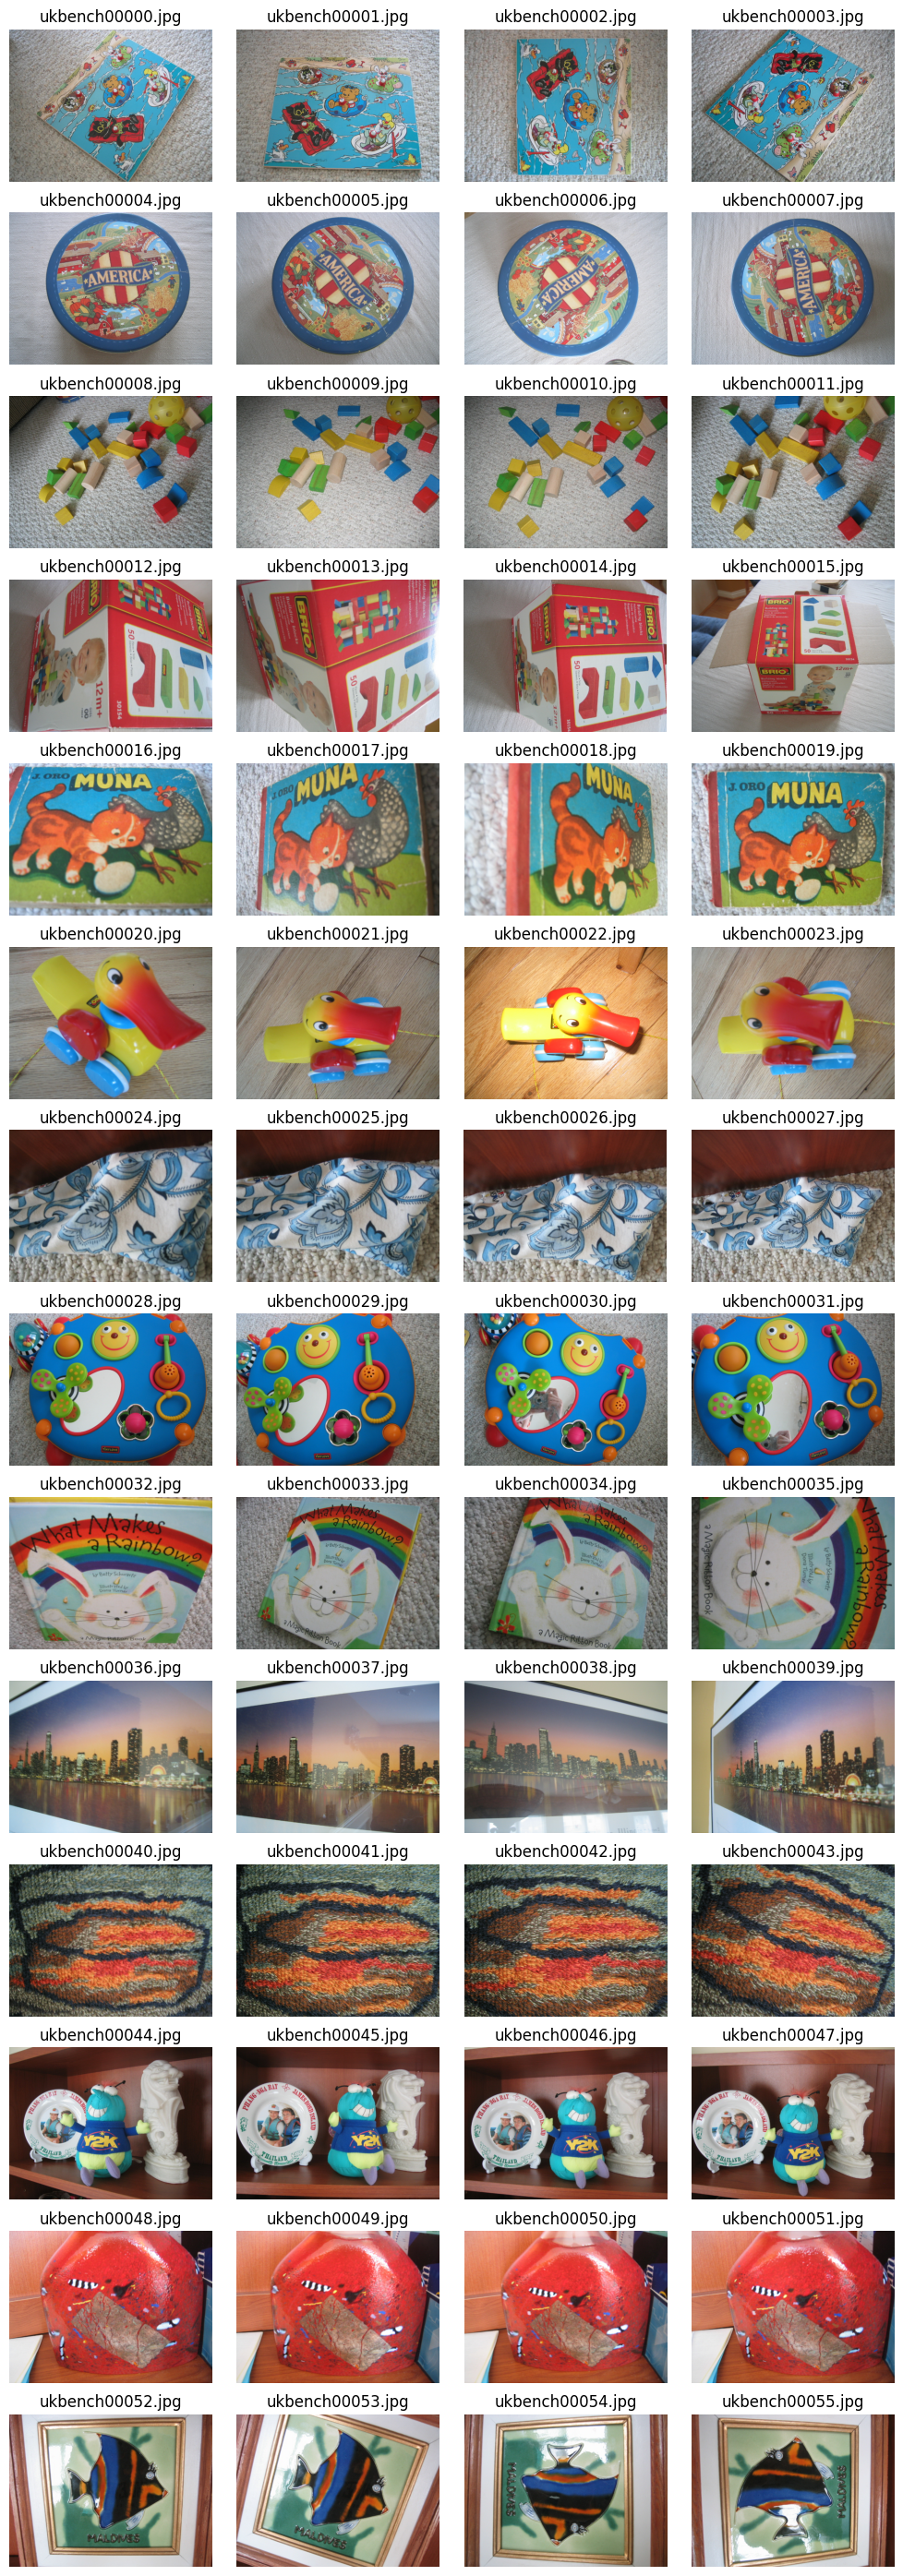

In [5]:
images, titles = compile_img(path)
num_rows = int(np.ceil(len(images) / 4))
plt.figure(figsize=(10, 2 * num_rows))
for idx, img in enumerate(images):
  plt.subplot(num_rows, 4, idx + 1)
  show_img(img, titles[idx])
plt.tight_layout()

In [6]:
for idx, img in enumerate(images):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  img = cv2.GaussianBlur(img, (5, 5), 0)
  images[idx] = img

# Collect SIFT Descriptors from The Images

In [7]:
SIFT = cv2.SIFT_create()

In [8]:
def generate_SIFT(images):
  descriptors = []
  keypoints = []
  for img in images:
    keypoint, descriptor = SIFT.detectAndCompute(img, None)
    descriptor = descriptor.astype('f')
    descriptors.append(descriptor)
    keypoints.append(keypoint)
  return descriptors, keypoints

In [9]:
descriptors, _ = generate_SIFT(images)

In [10]:
def stack_descriptor(descriptors):
  stacked_desc = descriptors[0]
  for i in descriptors[1:]:
    stacked_desc = np.vstack((stacked_desc, i))
  stacked_desc = np.float32(stacked_desc)
  return stacked_desc

In [11]:
stacked_desc = stack_descriptor(descriptors)

# Clustering Descriptors using K Means

> The center of these clusters are the "visual words" which represent the key features in the database of images.

In [12]:
kmeans = KMeans(n_clusters=num_rows, init='k-means++')
kmeans.fit(stacked_desc)
centroids = kmeans.cluster_centers_

# Create The Vector V For Every Image

> To represent each image in the dataset, this step will initialize a K-dimensional vector where K is the number of features in the dictionary. Then, the closest cluster center for every image will be determined using Euclidean distance for each feature.

In [13]:
def create_vector_v(images, descriptors, centroids):
  v = np.zeros((len(images), len(centroids)), 'float32')
  for idx, descriptor in enumerate(descriptors):
    for feature in descriptor:
      clusters, _ = vq([feature], centroids)
      for cluster in clusters:
        v[idx][cluster] += 1
  return v

In [14]:
v = create_vector_v(images, descriptors, centroids)

In [15]:
print(f'Total Descriptor on The First Image: {descriptors[0].shape[0]}')
print(f'Total Descriptor on The First Cluster of The First Image: {int(v[0][0])}')

Total Descriptor on The First Image: 2242
Total Descriptor on The First Cluster of The First Image: 160


> Each element of the K-dimensional vector for an image represents the number of descriptors assigned to a particular cluster. As example, the first image has a total of 2242 descriptors and a total of 247 descriptors closest to the first cluster center.

# Normalize Vector V

> The objective of this step is to make images with very different number of SIFT key-points found can be made comparable.

In [16]:
def normalize_vector_v(v):
  norm_v = v.copy()
  norm_v /= v.sum()
  return norm_v

In [17]:
norm_v = normalize_vector_v(v)

# Check Similarity with Query Image

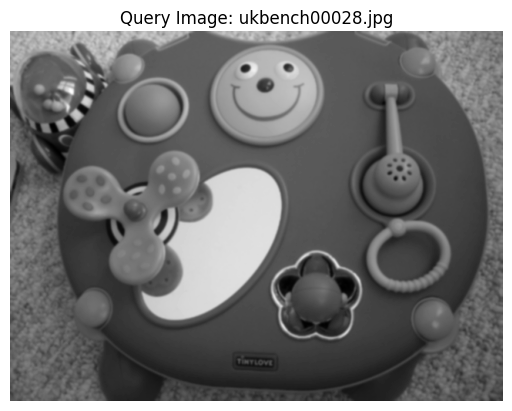

In [18]:
show_img(images[28], 'Query Image: '+titles[28], 'gray')

> The cosine similarity formula to evaluate how close the query image with images in the dataset based on:

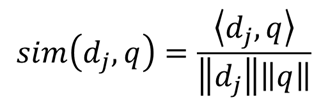

In [19]:
def calc_similarity(v, v_query):
  similarity = []
  for idx, i in enumerate(v):
    sim = np.dot(i, v_query) / (np.linalg.norm(i) * np.linalg.norm(v_query))
    similarity.append((sim, idx))

  result = sorted(similarity, reverse=True)
  return result

In [20]:
result = calc_similarity(norm_v, norm_v[28])

In [21]:
for i, j in result:
  print(f'Image {titles[j]} has similarity {i} with Image Query')

Image ukbench00028.jpg has similarity 1.0 with Image Query
Image ukbench00031.jpg has similarity 0.9820586442947388 with Image Query
Image ukbench00029.jpg has similarity 0.9780420660972595 with Image Query
Image ukbench00030.jpg has similarity 0.9720661640167236 with Image Query
Image ukbench00002.jpg has similarity 0.9450260996818542 with Image Query
Image ukbench00001.jpg has similarity 0.9439284801483154 with Image Query
Image ukbench00000.jpg has similarity 0.9338046312332153 with Image Query
Image ukbench00008.jpg has similarity 0.9317206740379333 with Image Query
Image ukbench00034.jpg has similarity 0.9296034574508667 with Image Query
Image ukbench00033.jpg has similarity 0.9275214076042175 with Image Query
Image ukbench00003.jpg has similarity 0.9156090617179871 with Image Query
Image ukbench00017.jpg has similarity 0.897573709487915 with Image Query
Image ukbench00032.jpg has similarity 0.892997145652771 with Image Query
Image ukbench00011.jpg has similarity 0.892752408981323

> Hence, here is the Top 3 Images with the Highest Similarity with Image Query:

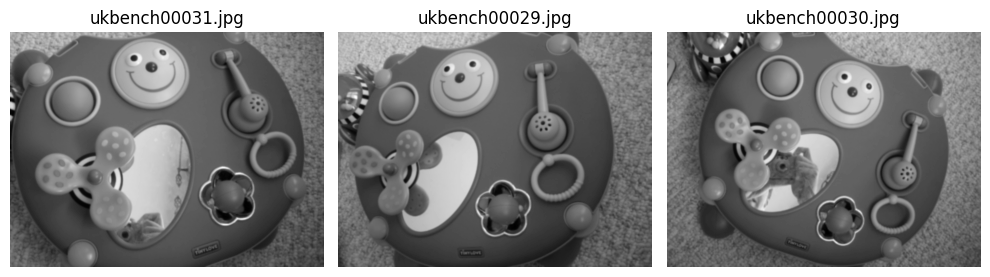

In [22]:
plt.figure(figsize=(10, 5))
for i in range(0, 3):
  plt.subplot(1, 3, i + 1)
  show_img(images[result[i+1][1]], titles[result[i+1][1]], 'gray')
plt.tight_layout()